## Data

In [1]:
from data_utils import create_joint_x_y
from sklearn.preprocessing import StandardScaler
import numpy as np

from tqdm.auto import tqdm


num_points_to_generate = 1000
num_latent_points_to_generate = 1000


scaler = StandardScaler()
X, Y = create_joint_x_y(num_points_to_generate)
X_test, Y_test = create_joint_x_y(num_points_to_generate)
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

n, d = Y.shape
U = np.random.normal(size=(num_latent_points_to_generate, d))
m = U.shape[0]

nu = np.ones((n, 1)) / n
mu = np.ones((m, 1)) / m

## ICNN 

In [2]:
import gc
from scipy import linalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

In [3]:
import sys
sys.path.insert(0, '../third_party/cp-flow')
from lib.flows import SequentialFlow, DeepConvexFlow, LinearIAF
from lib.icnn import ICNN3, PICNN
from lib import distributions
from data.toy_data import Gaussian as ToyData
from lib.utils import makedirs

In [4]:
depth = 5
k = 64
lr = 0.05
factor = 0.5
patience = 2000
num_epochs = 100
print_every = 10

batch_size_train = 128
batch_size_test = 64

dimx = d
dimc = X_scaled.shape[1]

if dimx == 2:
    m = np.array([1.5, 1.0])
    C = np.array([[0.9, -0.75], [-0.75, 0.9]])  # fixed for visualization
else:
    m = None
    C = None


In [5]:
dimx

2

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32, device=device)
Y_tensor = torch.tensor(Y, dtype=torch.float32, device=device)

X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32, device=device)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_scaled_tensor, Y_tensor),
    batch_size=batch_size_train,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test_scaled_tensor, Y_test_tensor),
    batch_size=batch_size_test,
    shuffle=True,
)

In [8]:
results = list()

In [9]:
# icnn = ICNN3(dimx, k, depth, symm_act_first=False, softplus_type='gaussian_softplus', zero_softplus=True)
icnn = PICNN(dim=dimx, dimh=k, dimc=dimc, num_hidden_layers=depth, symm_act_first=False, softplus_type='gaussian_softplus', zero_softplus=True)

flow = SequentialFlow(
    [DeepConvexFlow(icnn, dimx, unbiased=False, bias_w1=-0.0)]
)

In [10]:
optim = torch.optim.Adam(flow.parameters(), lr=lr)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(optim, num_epochs * len(train_loader), eta_min=0)

cuda = torch.cuda.is_available()
if cuda:
    flow = flow.cuda()

In [11]:
# init
for cond, y in train_loader:
    if cuda:
        cond = cond.cuda()
        y = y.cuda()
    flow.logp(y, context=cond).mean()
    print(f"cond.shape: {cond.shape}")
    print(f"y.shape: {y.shape}")
    print(f"flow.logp(y, context=cond).shape: {flow.logp(y, context=cond).shape}")
    print(f"flow.logp(y, context=cond).mean().shape: {flow.logp(y, context=cond).mean().shape}")
    break

cond.shape: torch.Size([128, 1])
y.shape: torch.Size([128, 2])
flow.logp(y, context=cond).shape: torch.Size([128])
flow.logp(y, context=cond).mean().shape: torch.Size([])


In [ ]:
def estimate_l2():
    l2 = 0
    count = 0
    for cond, x_test in test_loader:
        x_test = x_test.view(-1, dimx)
        if cuda:
            x_test = x_test.cuda()
            cond = cond.cuda()
        z = flow.flows[0](x_test, context=cond)
        l2 += torch.sum((x_test - z)**2).item()
        count += x_test.size(0)
    return l2 / count

In [ ]:
# gt = ot(train_loader.dataset.m, train_loader.dataset.C)

loss_acc = 0
t = 0
grad_norm = 0

flow.train()
init_l2 = estimate_l2()
# entropy = train_loader.dataset.entropy
losses = list()
estimates = list()
for e in tqdm(range(num_epochs) ):
    for cond, x in train_loader:
        x = x.view(-1, dimx)
        if cuda:
            x = x.cuda()
            cond = cond.cuda()

        loss = - flow.logp(x, context=cond).mean()
        optim.zero_grad()
        loss.backward()

        grad_norm = torch.nn.utils.clip_grad.clip_grad_norm_(flow.parameters(), max_norm=10).item()

        optim.step()
        sch.step()

        loss_acc += loss.item() #- entropy
        del loss
        gc.collect()
        torch.clear_autocast_cache()

        t += 1
        if t == 1:
            print('init loss:', loss_acc, grad_norm)
            # print('\t', gt, init_l2)

            losses.append(loss_acc)
            estimates.append(init_l2)

        if t % print_every == 0:
            print(t, loss_acc / print_every, grad_norm)
            losses.append(loss_acc / print_every)
            loss_acc = 0
            estimate = estimate_l2()
            # print(f'\t ground truth: {gt}, estimate: {estimate}')
            print(f'\t estimate: {estimate}')
            estimates.append(estimate)

results.append([losses, estimates])

  0%|          | 0/100 [00:00<?, ?it/s]

/home/nkotelevskii/github/conditional_quantile_function/vector_quantile_regression/notebooks/../third_party/cp-flow/lib/flows/cpflows.py:164: UserWarning: brute force
  warnings.warn('brute force')


init loss: 36.559303283691406 42.519020080566406
10 17.991418647766114 61.86686325073242
	 estimate: 132.00241455078125
20 6.375929307937622 7.9076008796691895
	 estimate: 49.76013354492188
30 4.115670704841614 5.6236090660095215
	 estimate: 48.58214245605469
40 3.9552444219589233 0.9748560190200806
	 estimate: 54.42140014648437
50 3.8262938976287844 1.4126554727554321
	 estimate: 59.88951342773437
60 3.775093126296997 1.0834177732467651
	 estimate: 61.215904541015625
70 3.611579489707947 1.1742970943450928
	 estimate: 59.90471044921875
80 3.6876333713531495 4.253847122192383
	 estimate: 64.76930786132813
90 3.5978790760040282 2.1300153732299805
	 estimate: 61.41185009765625
100 3.568642497062683 2.998741626739502
	 estimate: 60.2034638671875
110 3.5267119884490965 1.6243079900741577
	 estimate: 60.03083056640625
120 3.4959401369094847 0.5565237402915955
	 estimate: 58.60438269042969
130 3.5234009981155396 2.016510486602783
	 estimate: 60.1336083984375
140 3.503839373588562 2.210050821

In [17]:
makedirs('figures/OT')


def savefig(fn):
    plt.savefig(f'figures/OT/{fn}')

In [18]:
flow_type = 'cpflow'

In [26]:
device_and_dtype_specifications = dict(dtype=torch.float32, device=device)

In [33]:
print(matplotlib.get_backend())   

qtagg


In [35]:
# matplotlib.use("QtAgg")

In [ ]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline

from data_utils import create_conditional_x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100])[:, None]

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x_/100)
    z_scatter = np.full(y_x_gt.shape[0], x)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):

    x = torch.tensor([x_ / 100], **device_and_dtype_specifications)[:, None]
    x = x.repeat(repeats=(100, 1))

    colors = ['red', 'purple', 'green', 'orange', 'blue']
    radii = [0.1, 0.5, 1., 1.5, 2]
    for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True

        # potential = phi_network(x, u_tensor)
        # pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        with torch.no_grad():
            z = flow.reverse(u_tensor, context=x)
            pushforward_of_u = z.cpu()

        z_line = x.detach().cpu().numpy()
        label = f'Radius {contour_radius}' if x_ == loop_start_value else ""
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

ImportError: Cannot load backend 'qtagg' which requires the 'qt' interactive framework, as 'headless' is currently running

/home/nkotelevskii/github/conditional_quantile_function/vector_quantile_regression/notebooks/../third_party/cp-flow/lib/flows/cpflows.py:164: UserWarning: brute force
  warnings.warn('brute force')


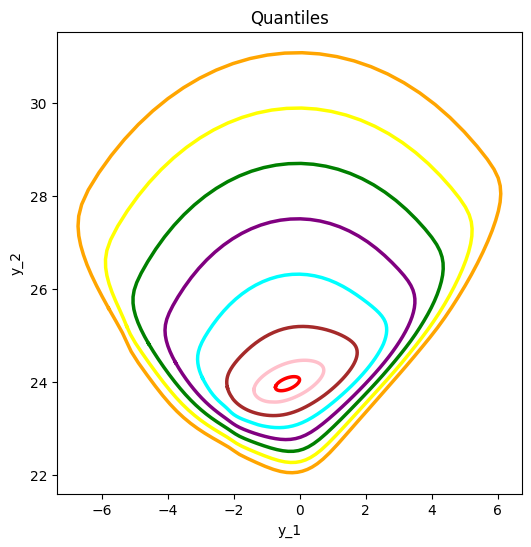

In [ ]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

ax1.set_title('Quantiles')
ax1.set_xlabel('y_1')
ax1.set_ylabel('y_2')
x = torch.tensor([2.4], **device_and_dtype_specifications)[:, None]
x = x.repeat(u_tensor.shape[0], 1)


colors = ['red', 'pink', 'brown', 'cyan', 'purple', 'green', 'yellow', "orange"]
radii = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 5]
for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True


        # potential = phi_network(x, u_tensor)
        # pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]
        with torch.no_grad():
            z = flow.reverse(u_tensor, context=x)
            pushforward_of_u = z.cpu()

        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], color=color, linewidth=2.5)
